In [ ]:
# default_exp models.nbeats

In [ ]:
# hide
import sys

sys.path.append("..")

# N-Beats model

> A basic architecture for time series forecasting.


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *

from fastseq.all import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export

def linspace(lookback, horizon):
    lin_space = np.linspace(
        -lookback, horizon, lookback + horizon
    )
    b_ls = lin_space[:lookback]
    f_ls = lin_space[lookback:]
    return b_ls, f_ls

class Block(Module):
    def __init__(
        self,
        units,
        thetas_dim,
        device,
        lookback=10,
        horizon=5,
        share_thetas=False,
    ):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.lookback = lookback
        self.horizon = horizon
        self.share_thetas = share_thetas
        self.fc1 = LinBnDrop(lookback, units)
#         self.fc2 = LinBnDrop(units, units)
#         self.fc3 = LinBnDrop(units, units)
        self.fc4 = LinBnDrop(units, units)
        self.device = device
        self.backcast_linspace, self.forecast_linspace = linspace(
            lookback, horizon
        )
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinBnDrop(units, thetas_dim)
        else:
            self.theta_b_fc = LinBnDrop(units, thetas_dim)
            self.theta_f_fc = LinBnDrop(units, thetas_dim)
        self.to(device)
        
    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.device)))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return (
            f"{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, "
            f"lookback={self.lookback}, horizon={self.horizon}, "
            f"share_thetas={self.share_thetas}) at @{id(self)}"
        )

Block(units=256, thetas_dim=8, device=torch.device('cuda'))

Block(
  (fc1): LinBnDrop(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=10, out_features=256, bias=False)
  )
  (fc4): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=256, bias=False)
  )
  (theta_b_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=8, bias=False)
  )
  (theta_f_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=8, bias=False)
  )
)

In [ ]:
# export

class GenericBlock(Block):
    def __init__(
        self, units, thetas_dim, device, lookback=10, horizon=5
    ):
        super(GenericBlock, self).__init__(
            units, thetas_dim, device, lookback, horizon
        )

        self.backcast_fc = nn.Linear(thetas_dim, lookback)
        self.forecast_fc = nn.Linear(thetas_dim, horizon)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = F.relu(self.theta_b_fc(x))
        theta_f = F.relu(self.theta_f_fc(x))

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast
    
GenericBlock(units=256,thetas_dim=8,device=torch.device('cuda'))

GenericBlock(
  (fc1): LinBnDrop(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=10, out_features=256, bias=False)
  )
  (fc4): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=256, bias=False)
  )
  (theta_b_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=8, bias=False)
  )
  (theta_f_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=8, bias=False)
  )
  (backcast_fc): Linear(in_features=8, out_features=10, bias=True)
  (forecast_fc): Linear(in_features=8, out_features=5, bias=True)
)

In [ ]:
# export

def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p < 10, "thetas_dim is too big."
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()  # H/2-1
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))

class SeasonalityBlock(Block):
    def __init__(
        self, units, thetas_dim, device, lookback=10, horizon=5
    ):
        super(SeasonalityBlock, self).__init__(
            units,
            thetas_dim,
            device,
            lookback,
            horizon,
            share_thetas=True,
        )

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(
            self.theta_b_fc(x), self.backcast_linspace, self.device
        )
        forecast = seasonality_model(
            self.theta_f_fc(x), self.forecast_linspace, self.device
        )
        return backcast, forecast
SeasonalityBlock(units=256,thetas_dim=8,device=torch.device('cuda'))

SeasonalityBlock(
  (fc1): LinBnDrop(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=10, out_features=256, bias=False)
  )
  (fc4): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=256, bias=False)
  )
  (theta_f_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=8, bias=False)
  )
  (theta_b_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=8, bias=False)
  )
)

In [ ]:
# export

def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, "thetas_dim is too big."
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))

class TrendBlock(Block):
    def __init__(
        self, units, thetas_dim, device, lookback=10, horizon=5
    ):
        super(TrendBlock, self).__init__(
            units,
            thetas_dim,
            device,
            lookback,
            horizon,
            share_thetas=True,
        )

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast
    
TrendBlock(units=256, thetas_dim=4, device=torch.device('cpu'), lookback=100, horizon=10)


TrendBlock(
  (fc1): LinBnDrop(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=100, out_features=256, bias=False)
  )
  (fc4): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=256, bias=False)
  )
  (theta_f_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=4, bias=False)
  )
  (theta_b_fc): LinBnDrop(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=4, bias=False)
  )
)

In [ ]:
# export
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F


class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = "seasonality"
    TREND_BLOCK = "trend"
    GENERIC_BLOCK = "generic"

    def __init__(
        self,
        device,
        stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dims=(2, 8),
        share_weights_in_stack=True,
        hidden_layer_units=2048,
    ):
        super(NBeatsNet, self).__init__()
        self.horizon = horizon
        self.lookback = lookback
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dims
        self.parameters = []
        self.device = device
        print(f"| N-Beats")
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(
            f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})"
        )
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units,
                    self.thetas_dim[stack_id],
                    self.device,
                    self.lookback,
                    self.horizon,
                )
                self.parameters.extend(block.parameters())
            print(f"     | -- {block}")
            blocks.append(block)
        return blocks

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def forward(self, backcast):
        backcast = backcast[:,0,:]
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return forecast[:,None,:]



In [ ]:
net = NBeatsNet(stack_types=[NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK],
                horizon=14,
                thetas_dims=[7, 8],
                nb_blocks_per_stack=3,
                lookback=140,
                hidden_layer_units=2048,
                share_weights_in_stack=True,
                device=torch.device('cuda'))

| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=True)
     | -- TrendBlock(units=2048, thetas_dim=7, lookback=140, horizon=14, share_thetas=True) at @140440403571408
     | -- TrendBlock(units=2048, thetas_dim=7, lookback=140, horizon=14, share_thetas=True) at @140440403571408
     | -- TrendBlock(units=2048, thetas_dim=7, lookback=140, horizon=14, share_thetas=True) at @140440403571408
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=2048, thetas_dim=8, lookback=140, horizon=14, share_thetas=True) at @140440403512784
     | -- SeasonalityBlock(units=2048, thetas_dim=8, lookback=140, horizon=14, share_thetas=True) at @140440403512784
     | -- SeasonalityBlock(units=2048, thetas_dim=8, lookback=140, horizon=14, share_thetas=True) at @140440403512784


In [ ]:
# export
from fastai2.basics import *
from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataBunch, output_channels=None, metrics=None, **kwargs):
    "Build a N-Beats style learner"    
    model = NBeatsNet(
        device = dbunch.train_dl.device,
        horizon = dbunch.train_dl.horizon,
        lookback = dbunch.train_dl.lookback, 
        **kwargs
       )
    model = model.to(dbunch.train_dl.device)
    
    learn = Learner(dbunch, model, loss_func=smape, opt_func= Adam, metrics=L(metrics)+L(mae))
    return learn

In [ ]:

path = untar_data(URLs.m4_daily)
data = TSDataBunch.from_folder(path, horizon = 14, lookback = 128, bs = 16, nrows=4)
learn = nbeats_learner(data)

| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=True)
     | -- TrendBlock(units=2048, thetas_dim=2, lookback=128, horizon=14, share_thetas=True) at @140440402981520
     | -- TrendBlock(units=2048, thetas_dim=2, lookback=128, horizon=14, share_thetas=True) at @140440402981520
     | -- TrendBlock(units=2048, thetas_dim=2, lookback=128, horizon=14, share_thetas=True) at @140440402981520
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=2048, thetas_dim=8, lookback=128, horizon=14, share_thetas=True) at @140440403682128
     | -- SeasonalityBlock(units=2048, thetas_dim=8, lookback=128, horizon=14, share_thetas=True) at @140440403682128
     | -- SeasonalityBlock(units=2048, thetas_dim=8, lookback=128, horizon=14, share_thetas=True) at @140440403682128


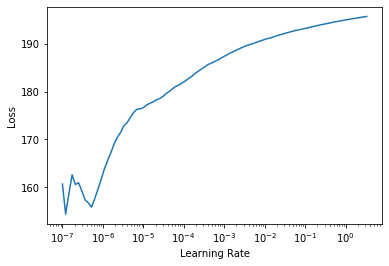

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

In [ ]:
learn.fit(1, 1e-4)

epoch,train_loss,valid_loss,mae,time
0,152.381012,160.215668,9031.271484,01:24


AttributeError: 'Learner' object has no attribute 'plot_losses'

In [ ]:
learn.fit(1, 1e-7)

epoch,train_loss,valid_loss,mae,time
0,149.165878,160.203873,9031.491211,01:25


In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 10_models.nbeats.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
